# Phrase Quest

This analysis is intended as a step toward an application called Phrase Quest. Phrase Quest is a game to associate phrases with places to create a geographic road tour map out of these associations. The hope is to create a snapshot of a road tour out of phrases, colloquialisms, key words in scientific fields, inside jokes, or song lyrics. 


In the technical details, the application will map discrete data in four dimensions to real data in two dimensions. While this is a broadly applicable technical task, I am applying it the specific problem of creating a simplistic secret code based on airport name data and latitudes and longitudes from OpenFlights.org. I have explored using Twitter data but do not currently have a Twitter developer's licence.  . 

In [197]:
#!/usr/bin/python
import os, sys, random

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.stats import cauchy
import numpy as np
from io import StringIO
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LinearRegression



I begin by defining some functions that will be used later. These have to do with the scaling of the linguistic data and the processing of the text.

In [198]:


def powerlaw(x,a,b,c):
    return a*x**b+c

def f5(x,a,b,c,d,g,h):
    return a*x**5+b*x**4+c*x**3+d*x**2+g*x+h

def f3(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

def VowelToConsRatio(name):
    
    words = sum(c.isalpha() for c in name)
    spaces = sum(c.isspace() for c in name)
    others = len(name) - words - spaces
    vowels = sum(map(name.lower().count, "aeiou"))
    consonents = words - vowels


    return float(vowels)/float(consonents), float(spaces)/float(consonents), float(others)/float(consonents)



def AirportNameLetterFrequency(name):
    
    words = sum(c.isalpha() for c in name)
    spaces = sum(c.isspace() for c in name)
    others = len(name) - words - spaces
    vowels = sum(map(name.lower().count, "aeiou"))
    consonents = words - vowels
    #put a one at the end to account for one airport in number totaled. will be normalized later

    return consonents, vowels, spaces, others


def MergeCount(totalCount, thisCount):
    totalCount2=totalCount+thisCount
    return totalCount2


def transformphrase(testphrases,poly,clf):
    xphrases=[]
    for phrase in testphrases:
        print(phrase)
        vtc, stc, otc = VowelToConsRatio(phrase)
        xphrases.append([vtc,stc,otc])
    scaler=StandardScaler()
    xphrases2=scaler.fit_transform(xphrases)
    Poly_phrases=poly.fit_transform(xphrases2)
    Y_latlon=clf.predict(Poly_phrases)
    return Y_latlon



def LatLongClassMaker(coor):
    lat,long=coor
    if lat<30:
        if long>-90:
            return 1 #florida
        elif long < -120:
            return 2 #hawaii
        else:
            return 3 #texas
    elif lat >50:
        return 4 #alaska
    elif long> -80 and lat < 40:
        return 5 #south east
    elif long> -80 and lat >40:
        return 6 #new england
    elif long< -80:
        return int((50-lat)/20.*5)*int((125+long)/45.*9)+7
    else:
        return 0
    #worst mapping ever-- ignores new england and city diversity
    return 0







This data contains airports, train stops, and bus terminals throughout the world supplied by users. 

In [199]:
file = open("airports-extended.dat.txt","r")

# Histograms of scaling of language data

In [200]:
totalUSAcount=np.zeros(5)
totalChinacount=np.zeros(5)
totalEnglandcount=np.zeros(5)
totalFrancecount=np.zeros(5)
totalGermanycount=np.zeros(5)
totalMexicocount=np.zeros(5)
totalCanadacount=np.zeros(5)



#I picked some countries I have familiarity with so I know whether or not the data makes sense when I see it, sort of.

#what I want is the histogram of counts within each country to compare distributions between countries by eye. I can then look at a regression within the US by longitude and lattitude (actual distance from Chicago?) if it looks interesting

Chinavowel=[]
Chinacons=[]
USvowel=[]
UScons=[]
Englandvowel=[]
Englandcons=[]
Francevowel=[]
Francecons=[]
Germanyvowel=[]
Germanycons=[]
Mexicovowel=[]
Mexicocons=[]
Canadavowel=[]
Canadacons=[]

for line in file:
    line=re.split(',',line);
    if line[3] == "\"China\"":
        thisChinacount = AirportNameLetterFrequency(line[1])
        Chinavowel.append(thisChinacount[1])
        Chinacons.append(thisChinacount[0])
    if line[3] == "\"United States\"":
        thisUSAcount = AirportNameLetterFrequency(line[1])
        USvowel.append(thisUSAcount[1])
        UScons.append(thisUSAcount[0])
    
    if line[3] == "\"United Kingdom\"":
        thisEnglandcount = AirportNameLetterFrequency(line[1])
        Englandvowel.append(thisEnglandcount[1])
        Englandcons.append(thisEnglandcount[0])
    
    if line[3] == "\"France\"":
        thisFrancecount = AirportNameLetterFrequency(line[1])
        Francevowel.append(thisFrancecount[1])
        Francecons.append(thisFrancecount[0])
    
    if line[3] == "\"Germany\"":
        thisGermanycount = AirportNameLetterFrequency(line[1])
        Germanyvowel.append(thisGermanycount[1])
        Germanycons.append(thisGermanycount[0])
    
    if line[3] == "\"Mexico\"" :
        thisMexicocount = AirportNameLetterFrequency(line[1])
        Mexicovowel.append(thisMexicocount[1])
        Mexicocons.append(thisMexicocount[0])
    if line[3] == "\"Canada\"" :
        thisCanadacount = AirportNameLetterFrequency(line[1])
        Canadavowel.append(thisCanadacount[1])
        Canadacons.append(thisCanadacount[0])
        
                

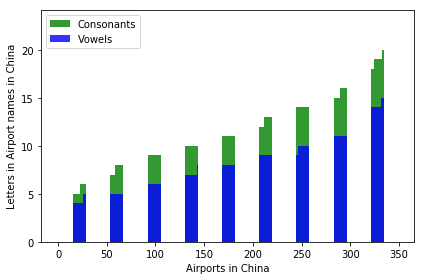

In [201]:
fig, ax = plt.subplots()
n_groups=len(Chinavowel)
index=np.arange(n_groups)
bar_width=0.35
opacity = 0.8
rects2 = plt.bar(index, np.sort(np.asarray(Chinacons)), bar_width, alpha=opacity, color='g', label='Consonants')
rects1 = plt.bar(index, np.sort(np.asarray(Chinavowel)), bar_width, alpha=opacity, color='b', label='Vowels')


plt.xlabel('Airports in China')
plt.ylabel('Letters in Airport names in China')
plt.legend()

plt.tight_layout()
plt.show()

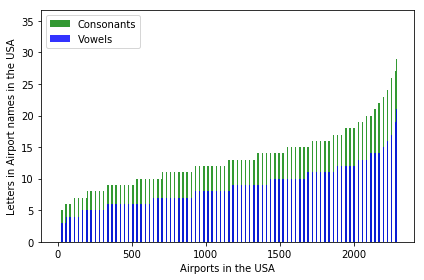

In [202]:
fig, ax = plt.subplots()
n_groups=len(USvowel)
index=np.arange(n_groups)
bar_width=0.35
opacity = 0.8
rects2 = plt.bar(index, np.sort(np.asarray(UScons)), bar_width, alpha=opacity, color='g', label='Consonants')
rects1 = plt.bar(index, np.sort(np.asarray(USvowel)), bar_width, alpha=opacity, color='b', label='Vowels')


plt.xlabel('Airports in the USA')
plt.ylabel('Letters in Airport names in the USA')
plt.legend()

plt.tight_layout()
plt.show()

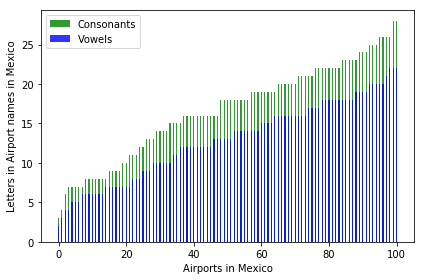

In [203]:
fig, ax = plt.subplots()
n_groups=len(Mexicovowel)
index=np.arange(n_groups)
bar_width=0.35
opacity = 0.8
rects2 = plt.bar(index, np.sort(np.asarray(Mexicocons)), bar_width, alpha=opacity, color='g', label='Consonants')
rects1 = plt.bar(index, np.sort(np.asarray(Mexicovowel)), bar_width, alpha=opacity, color='b', label='Vowels')


plt.xlabel('Airports in Mexico')
plt.ylabel('Letters in Airport names in Mexico')
plt.legend()

plt.tight_layout()
plt.show()

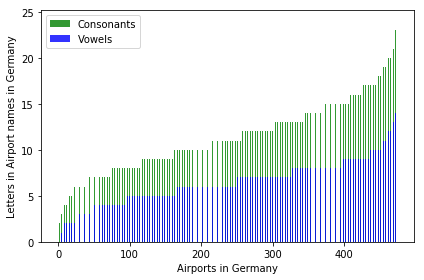

In [204]:
fig, ax = plt.subplots()
n_groups=len(Germanyvowel)
index=np.arange(n_groups)
bar_width=0.35
opacity = 0.8
rects2 = plt.bar(index, np.sort(np.asarray(Germanycons)), bar_width, alpha=opacity, color='g', label='Consonants')
rects1 = plt.bar(index, np.sort(np.asarray(Germanyvowel)), bar_width, alpha=opacity, color='b', label='Vowels')


plt.xlabel('Airports in Germany')
plt.ylabel('Letters in Airport names in Germany')
plt.legend()

plt.tight_layout()
plt.show()

# Making discrete data continuous

I use a standard technique in machine learning to make discrete data continuous. I take a ratio of two discrete quantities, in particular the consonant symbol count forms the denomonator. Rehistogramming, I seek to find a fit to the shape of the scaling so that I may transform the data for a regression.

In [205]:
file = open("airports-extended.dat.txt","r")
totalUSAcount=np.zeros(5)
totalChinacount=np.zeros(5)
totalEnglandcount=np.zeros(5)
totalFrancecount=np.zeros(5)
totalGermanycount=np.zeros(5)
totalMexicocount=np.zeros(5)
totalCanadacount=np.zeros(5)



#I picked some countries I have familiarity with so I know whether or not the data makes sense when I see it, sort of.

#what I want is the histogram of counts within each country to compare distributions between countries by eye. I can then look at a regression within the US by longitude and lattitude (actual distance from Chicago?) if it looks interesting


Chinaratio=[]
USAratio=[]
Englandratio=[]
Germanyratio=[]
Franceratio=[]
Canadaratio=[]
Mexicoratio=[]

for line in file:
    line=re.split(',',line);
#    if line[3] == "\"China\"":
#        thisChinaratio = VowelToConsRatio(line[1])
#        Chinaratio.append(thisChinaratio)
    if line[3] == "\"United States\"":
        thisUSAratio = VowelToConsRatio(line[1])
        USAratio.append(thisUSAratio)
    if line[3] == "\"United Kingdom\"":
        thisEnglandratio = VowelToConsRatio(line[1])
        Englandratio.append(thisEnglandratio)
    
    if line[3] == "\"France\"":
        thisFranceratio = VowelToConsRatio(line[1])
        Franceratio.append(thisFranceratio)
    
    
    if line[3] == "\"Germany\"":#
        thisGermanyratio = VowelToConsRatio(line[1])
        Germanyratio.append(thisGermanyratio)
    
    if line[3] == "\"Mexico\"" :
        thisMexicoratio = VowelToConsRatio(line[1])
        Mexicoratio.append(thisMexicoratio)
    if line[3] == "\"Canada\"" :
        thisCanadaratio = VowelToConsRatio(line[1])
        Canadaratio.append(thisCanadaratio)
        
                
Canadaarr=np.asarray(Canadaratio)
Canadaarr.sort()
USAarr=np.asarray(USAratio)
USAarr.sort()
UKarr=np.asarray(Englandratio)
UKarr.sort()
Francearr=np.asarray(Franceratio)
Francearr.sort()
Germanyarr=np.asarray(Germanyratio)
Germanyarr.sort()
Mexicoarr=np.asarray(Mexicoratio)
Mexicoarr.sort()


In [206]:
np.shape(USAarr)

(2294, 3)

In [207]:
from bokeh.plotting import figure, output_notebook, show

n_groups=len(USAratio)
index=np.arange(n_groups)
p = figure(plot_width=400, plot_height=400, title="Vowels/Consonants ratio, sorted", x_axis_label="Airports in the USA", y_axis_label="Letter ratio in Airport names in the USA")
p.vbar(x=index, width=0.5, bottom=0, top=np.sort(USAarr[:,0]), color='blue')
output_notebook()
show(p)

Loading BokehJS ...

Fit power law to reversed histogram

In [208]:
xdat=np.arange(len(USAarr))
ydat0=np.sort(USAarr[:,0])
ydat=ydat0[::-1]
par=[1.,1.,1.,1.]
p0=par
par,pvar=curve_fit(powerlaw,xdat,ydat)


In [209]:
def powerlaw(x,a,b,c):
    return a*x**b+c


In [210]:
p=figure(height=400,width=400,title="Power law fit to v/c histogram", x_axis_label="v/c", y_axis_label="ratio of counts")
p.vbar(x=index, width=0.5, bottom=0, top=ydat, color='cyan', legend='v/c data')
p.line(index, powerlaw(index,par[0],par[1],par[2]),color='black', legend='power law fit')
output_notebook()
show(p)

Loading BokehJS ...

In [211]:
par

array([-0.1001773 ,  0.16004007,  0.44202822])

In [212]:
def powerlawnooffset(x,a,b):
    return a*x**b

Fit third order polynomial to histogram.

In [213]:
xdat=np.arange(len(USAarr))
ydat0=np.sort(USAarr[:,0])
ydat=ydat0[::-1]
par=[1.,1.,1.,1.]
p0=par
par,pvar=curve_fit(f3,xdat,ydat)




In [214]:
par

array([-5.12135196e-11,  1.87354057e-07, -2.47822462e-04,  2.54307005e-01])

In [215]:
p=figure(height=400,width=400,title="Third order polynomial fit to v/c histogram", x_axis_label="v/c", y_axis_label="ratio of counts")
p.vbar(x=index, width=0.5, bottom=0, top=ydat, color='cyan', legend='v/c data')
p.line(index, f3(index,par[0],par[1],par[2],par[3]),color='black', legend='Third order polynomial fit')
output_notebook()
show(p)

Loading BokehJS ...

In [216]:
par

array([-5.12135196e-11,  1.87354057e-07, -2.47822462e-04,  2.54307005e-01])

It looks like it's a blend of third order polynomial and power law. Probably the best fit could be achieved by matching the two in some buffer region by matching the derivatives smoothly at the inflection point. I have not yet tried this. To preliminarily investigate, I used a third order power law.

# Polynomial transformation and linear regression

To produce a map of phrases to places, I performed a polynomial transformation and linear regression in multiple dimensions using the scikit-learn toolkit in python.

In [217]:
file = open("airports-extended.dat.txt","r")
ratio=[]
coords=[]


for line in file:
    line=re.split(',',line);

    if line[3] == "\"United States\"":
        thisratioV, thisratioS, thisratioO=VowelToConsRatio(line[1]);
        ratio.append([thisratioV,thisratioS,thisratioO])
        coords.append([float(line[6]),float(line[7])])


ratioarray=np.empty([len(ratio),3])
coordsarray=np.empty([len(coords),2])
regionarray=np.empty([len(coords)])

for i, rat in enumerate(ratio):
    ratioarray[i,:]=rat
for i,coor in enumerate(coords):
    coordsarray[i,:]=coor
#    outputcoor=LatLongClassMaker(coor)
#    regionarray[i]=outputcoor

xtrain,xtest,ytrain,ytest=train_test_split(ratioarray,coordsarray,test_size=0.33,shuffle=True, random_state=random.randint(1,101))

These test phrases are phrases I gathered from myself, my sister who lives abroad, my parents, and the chair of my masters exam committee from Louisiana State University who works in Loop Quantum Gravity. I wrote both a fairly broad selection of phrases and a set of songs. My sister used inside jokes. My father used songs. My mother used colloquialisms. My committee chair used key words from the field in the word cloud I harvested.

In [218]:
testphrases=["Ufda!", "I just dont know about that", "Howdy, pardner", "Where are we?", 
             "I thank whatever gods may be for my unconquerable soul.", "I welcome our new robot overlords",
             "l33t h4k3rs", "I know you I walked with you once upon a dream", 
             "These stories dont mean anything if you have no one to tell them to", 
             "Baby you have the sort of hands that rip me apart","Multi-messenger astronomy", 
             "Rainbow flag", "I prefer They or He?", "numerical relativity", "LIGO", "scalar field", 
             "Osculating Orbits", "Monte-Carlo Simulation", "Data Analysis", "Data Science", "Parallelization", 
             "Paralyzation", "Partial disability", "Non-epileptic seizures", "Wednesday Lunch", "Tuesday Lunch", 
             "Thursday Lunch", "Guild Wars", "Elvenar", "Good Apple"]

colleaguephrases=["general relativity", "black hole", "loop quantum gravity",  "quantization", "space-time", 
                  "Hamiltonian constraint", "Ashtekar", "LiSA", "LIGO", "group", "white hole", "scalar field",
                  "numerical relativity", "cosmology", "diffeomorphism", "continuum limit", "David Berger", 
                  "Reisner-Nordstrom", "black hole spacetime", "initial data", "interpretation of quantum mechanics"]


mysongs=["My gift is your song and this one’s for you.",
"I closed my eyes, drew back the curtain, to see for certain, what I thought I knew.",
"Mamma if you don’t mind my sayin so you have a bad habit of changing every subject. No I didn’t change the subject.",
"I did not live until today, how can I live when we are parted? One day more.",
"Pick a little talk a little pick a little talk a little cheep cheep cheep talk a lot pick a little more…",
"I’ll be your queen, and you’ll be my castle.",
"She’s wicked so we’ve got to bring her down. ",
"And all this science I don’t understand. It’s just my job five days a week.",
"A life time of not knowing where or how or why or when.",
"Mathematics isolation rhythm feeling power harmony and heavy competition.",
"I’m through playing by the rules of someone else’s game. Too late for second guesses too late to go back to sleep. It’s time to trust my instincts close my eyes and leap. It’s time to try defying gravity and you can’t pull me down.",
"Maybe far away, or maybe real nearby… ",
"SO IF YOU CARE TO FIND ME LOOK TO THE WESTERN SKY AS SOMEONE TOLD ME LATELY EVERYONE DESERVES A CHANCE TO FLY and if I’m flying solo at least I’m flying free to those who ground me take a lesson back from me. ",
"I’m sorry for everything I said and for everything I forgot to say too…"]

dadssongs=["1. Mars ain't no place to raise a kid. Besides it’s cold as hell",
"2. she’ll have fun, fun, fun till her daddy takes her T bird away",
"3. A man hears what he wants to hear, and disregards the rest",
"4. All revved up and no place to go",
"5. Why they changed it, I can’t say…people just liked it better that way",
"6. First you take a step to the left, then you jump to the right",
"7. Young man!!",
"8. And while I’m away, I’ll write home every day..and send all my lov’in to you",
"9. Each night before you go to bed, my baby, whisper a little prayer for me, my baby",
"10. Master of the house, keeper of the zoo",
"11. May you be forever young",
"12. Weave me the sunshine"]

momphrases=["I just don’t know about that.",
"Well that’s different.",
"Way to go!",
"That’s awesome!",
"In a little while…",
"Go to bed!",
"It’ll all work out."
"Sooner or later",
"Clean your room!",
"The one with the most fabric wins.",
"I’m off to sew!",
"It’s a great day!",
"How can I help?",
"Time to eat!",
"Read your book.",
"Are you ready?",
"I’m sure."]

sisterphrases=["1. Running down the dream", "2. How much is a gallon?", "3. Dead snake on a lake", 
               "4. Pseudaphed and tumbleweeds", "5. East Jesus Nowhere", "6. Taxation without representation", 
               "7. Old people, high schoolers and drug dealers", "8. it was a trial for... MURDER!", 
               "9. Rock lobster", "10. Trapeze hands", "11. Hinga Weezy", "12. Patty dance pants"]

 



In [219]:

xphrases=[]
for phrase in testphrases:
    print(phrase)
    vtc, stc, otc = VowelToConsRatio(phrase)
    xphrases.append([vtc,stc,otc])
xcolleague=[]
for phrase in colleaguephrases:
    print(phrase)
    vtc, stc, otc = VowelToConsRatio(phrase)
    xcolleague.append([vtc,stc,otc])



Ufda!
I just dont know about that
Howdy, pardner
Where are we?
I thank whatever gods may be for my unconquerable soul.
I welcome our new robot overlords
l33t h4k3rs
I know you I walked with you once upon a dream
These stories dont mean anything if you have no one to tell them to
Baby you have the sort of hands that rip me apart
Multi-messenger astronomy
Rainbow flag
I prefer They or He?
numerical relativity
LIGO
scalar field
Osculating Orbits
Monte-Carlo Simulation
Data Analysis
Data Science
Parallelization
Paralyzation
Partial disability
Non-epileptic seizures
Wednesday Lunch
Tuesday Lunch
Thursday Lunch
Guild Wars
Elvenar
Good Apple
general relativity
black hole
loop quantum gravity
quantization
space-time
Hamiltonian constraint
Ashtekar
LiSA
LIGO
group
white hole
scalar field
numerical relativity
cosmology
diffeomorphism
continuum limit
David Berger
Reisner-Nordstrom
black hole spacetime
initial data
interpretation of quantum mechanics


In [220]:
scaler = StandardScaler()
xtrain2=scaler.fit_transform(xtrain)
xtest2=scaler.fit_transform(xtest)
xphrases2=scaler.fit_transform(xphrases)
#xcolleague2=scaler.fit_transform(xcolleague)


In [221]:
poly=PolynomialFeatures(3)
Poly_test=poly.fit_transform(xtest)
Poly_train=poly.fit_transform(xtrain)
Poly_phrases=poly.fit_transform(xphrases)
#X_kpca_colleague=kpca.fit_transform(xcolleague2)

print(Poly_phrases[0])
print(Poly_train[0])
#print(X_kpca_colleague[0])

print(np.shape(Poly_train))
print(np.shape(ytrain))







[1.    1.    0.    0.5   1.    0.    0.5   0.    0.    0.25  1.    0.
 0.5   0.    0.    0.25  0.    0.    0.    0.125]
[1.00000000e+00 6.66666667e-01 1.42857143e-01 9.52380952e-02
 4.44444444e-01 9.52380952e-02 6.34920635e-02 2.04081633e-02
 1.36054422e-02 9.07029478e-03 2.96296296e-01 6.34920635e-02
 4.23280423e-02 1.36054422e-02 9.07029478e-03 6.04686319e-03
 2.91545190e-03 1.94363460e-03 1.29575640e-03 8.63837599e-04]
(1536, 20)
(1536, 2)


In [222]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

In [223]:
from sklearn.linear_model import Ridge
clf=Ridge(alpha=.001)

In [224]:
clf.fit(Poly_train,ytrain)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [225]:
latlongpred=clf.predict(Poly_test)

This figure shows that the validation set does not entirely reproduce the training set. There is a scale factor mismatch, and Alaska is missing. This is suspicious since both were produced through the same procedure (albeit without refitting the polynomial transformation or the ridge regression the second time). This is most likely due to the tail of the distribution where the polynomial form becomes a power law form. It would be a good idea to account for that by hand. 

In [226]:
p=figure(plot_width=600, plot_height=600, title="Training and Verification Data", x_axis_label="Longitude", y_axis_label="Latitude")
p.square(ytrain[:,1], ytrain[:,0], color="blue", legend="Coordinates of airport in training set")
p.circle(ytest[:,1],ytest[:,0],color="yellow", legend="Coordinates of airports in test set")
p.x(latlongpred[:,1],latlongpred[:,0], color="red", legend="Mappings of airport nanes to positions")
output_notebook()
show(p)

Loading BokehJS ...

# Splicing a power law and a polynomial

Both power law and polynomial forms are phenomenological models rather than theoretically predicted models. Since the mapping had a scale problem related to shrinking, my suspicion is that this can be improved by improving the phenomenological model for the coordinate transformation prior to the Ridge regression. To address this, I perform a least squares fit of a power law spliced to a polynomial. However, curve_fit cannot handle this because it cannot take if statements as input. Thus, I write my own routine.

In [227]:
from scipy.optimize import minimize

def powerlaw(x,a,b,c,d):
    return a*(x-d)**b+c

def f5(x,a,b,c,d,g,h):
    return a*x**5+b*x**4+c*x**3+d*x**2+g*x+h

def f3(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d







The boundary constraint is not completely trivial in closed form, so it is best solved numerically using minimization. The boundary condition is set by making the derivative smooth. 

In [228]:
file = open("airports-extended.dat.txt","r")
totalUSAcount=np.zeros(5)
totalChinacount=np.zeros(5)
totalEnglandcount=np.zeros(5)
totalFrancecount=np.zeros(5)
totalGermanycount=np.zeros(5)
totalMexicocount=np.zeros(5)
totalCanadacount=np.zeros(5)



#I picked some countries I have familiarity with so I know whether or not the data makes sense when I see it, sort of.

#what I want is the histogram of counts within each country to compare distributions between countries by eye. I can then look at a regression within the US by longitude and lattitude (actual distance from Chicago?) if it looks interesting


Chinaratio=[]
USAratio=[]
Englandratio=[]
Germanyratio=[]
Franceratio=[]
Canadaratio=[]
Mexicoratio=[]

for line in file:
    line=re.split(',',line);
#    if line[3] == "\"China\"":
#        thisChinaratio = VowelToConsRatio(line[1])
#        Chinaratio.append(thisChinaratio)
    if line[3] == "\"United States\"":
        thisUSAratio = VowelToConsRatio(line[1])
        USAratio.append(thisUSAratio)
    if line[3] == "\"United Kingdom\"":
        thisEnglandratio = VowelToConsRatio(line[1])
        Englandratio.append(thisEnglandratio)
    
    if line[3] == "\"France\"":
        thisFranceratio = VowelToConsRatio(line[1])
        Franceratio.append(thisFranceratio)
    
    
    if line[3] == "\"Germany\"":#
        thisGermanyratio = VowelToConsRatio(line[1])
        Germanyratio.append(thisGermanyratio)
    
    if line[3] == "\"Mexico\"" :
        thisMexicoratio = VowelToConsRatio(line[1])
        Mexicoratio.append(thisMexicoratio)
    if line[3] == "\"Canada\"" :
        thisCanadaratio = VowelToConsRatio(line[1])
        Canadaratio.append(thisCanadaratio)
        
                
Canadaarr=np.asarray(Canadaratio)
Canadaarr.sort()
USAarr=np.asarray(USAratio)
USAarr.sort()
UKarr=np.asarray(Englandratio)
UKarr.sort()
Francearr=np.asarray(Franceratio)
Francearr.sort()
Germanyarr=np.asarray(Germanyratio)
Germanyarr.sort()
Mexicoarr=np.asarray(Mexicoratio)
Mexicoarr.sort()


In [229]:
from scipy.optimize import least_squares
xdat=np.arange(len(USAarr))
ydat0=np.sort(USAarr[:,0])
ydat=ydat0[::-1]
pmine=[5.,-3.,0.5,1.,1.,1.,0.5]


In [230]:
len(xdat)/2

1147.0

The python command curve_fit doesn't work because of an if statement in the function to be fit. I suggest using a hand written least squares routine and a gradient descent minimization routine. First, I consider whether or not these four counting statistics truly behave as poisson distributed variables with a known uncertainty distirbution equal to the square root of the count so that a maximum likelihood fit could be used instead. For this, I need to use four variables instead of three and find out their functional forms (no ratio). I consider the consonant, verb, space, and other symbol count seperately. 

In [231]:
file = open("airports-extended.dat.txt","r")
words=[]
coords=[]


for line in file:
    line=re.split(',',line);

    if line[3] == "\"United States\"":
        thisC, thisV, thisS, thisO=AirportNameLetterFrequency(line[1]);
        words.append([thisC,thisV,thisS,thisO])
        coords.append([float(line[6]),float(line[7])])


wordarray=np.empty([len(words),4])
coordsarray=np.empty([len(coords),2])
regionarray=np.empty([len(coords)])

for i, sym in enumerate(words):
    wordarray[i,:]=sym
for i,coor in enumerate(coords):
    coordsarray[i,:]=coor
#    outputcoor=LatLongClassMaker(coor)
#    regionarray[i]=outputcoor

xtrain,xtest,ytrain,ytest=train_test_split(wordarray,coordsarray,test_size=0.33,shuffle=True, random_state=random.randint(1,101))


In [232]:
sortednamedata=np.sort(wordarray, axis=0)
ydat=np.fliplr(sortednamedata)
xdat=np.arange(len(ydat))
par0=[1.,1.,1.,1.]
parlist=[]
err=np.sqrt(ydat)
err[err==0]=1.
for i in np.arange(4):
    par,pvar=par1,pvar=curve_fit(f3,xdat,ydat[:,i],p0=p0,sigma=err[:,i],absolute_sigma=True)
    parlist.append(par)

In [233]:
print(np.max(ydat[:,0]))
print(ydat[0,0])
print(ydat[:,0])

6.0
2.0
[2. 2. 2. ... 6. 6. 6.]


In [234]:
from bokeh.plotting import figure, output_notebook, show, gridplot

s1=figure(plot_width=250, plot_height=250, title="Fit to airport name data", x_axis_label="Number of Consonants", y_axis_label="Count")
s1.vbar(x=xdat,width=0.5,bottom=0, top=ydat[:,0], color='cyan', legend='Consonant data')
s1.line(xdat, f3(xdat,parlist[0][0],parlist[0][1],parlist[0][2],parlist[0][3]),color='black', legend='Third order polynomial fit')


s2=figure(plot_width=250, plot_height=250, title="Fit to airport name data", x_axis_label="Number of Vowels", y_axis_label="Count")
s2.vbar(x=xdat, width=0.5,bottom=0,top=ydat[:,1], color='yellow', legend='Vowel data')
s2.line(xdat, f3(xdat,parlist[1][0],parlist[1][1],parlist[1][2],parlist[1][3]),color='black', legend='Third order polynomial fit')

s3=figure(plot_width=250, plot_height=250, title="Fit to airport name data", x_axis_label="Number of Spaces", y_axis_label="Count")
s3.vbar(x=xdat,width=0.5,bottom=0,top=ydat[:,2], color='orange', legend='Space data')
s3.line(xdat, f3(xdat,parlist[2][0],parlist[2][1],parlist[2][2],parlist[2][3]),color='black', legend='Third order polynomial fit')


s4=figure(plot_width=250, plot_height=250, title="Fit to airport name data", x_axis_label="Number of Symbols", y_axis_label="Count")
s4.vbar(x=xdat, width=0.5,bottom=0,top=ydat[:,3], color='green', legend='Symbol data')
s4.line(xdat, f3(xdat,parlist[3][0],parlist[3][1],parlist[3][2],parlist[3][3]),color='black', legend='Third order polynomial fit')

p=gridplot([[s1,s2],[s3,s4]])

output_notebook()
show(p)

Loading BokehJS ...

Clearly these are not poisson distributions. Back to the previous approach of using ratios to make discrete-ish data continuous. I will splice a polynomial to a power law to handle my scale problem and implement a least squares fit by hand.

In [235]:
def polypower(x,params,boundaryx):
    [a1,b1,c1,d1,a2,b2,c2,d2]=params
    xo=[]
    for xi in x:
    
        if(xi>boundaryx):
            xo.append(f3(x,a2,b2,c2,d2))
        else:
            xo.append(powerlaw(x,a1,b1,c1,d1))
    return xo

In [236]:
def polypowerboundaryconstraint(x,a1,b1,c1,d1,a2,b2,c2):
    def polypowerlawboundarysolve(x): 
        return a1*b1*(x-d1)**(b1-1)-(a2*3*x**2+b2*2*x+c2)
    return polypowerlawboundarysolve

def polypowerboundaryderivconstraint(xboundary,a1,b1,c1,d1,a2,b2):
    b2=-1/2.*(a1*b1*(b1-1)*(xboundary-d1)**(b1-2)-(a2*6*xboundary))
    return b2


In [237]:
#initial conditions

def polypowerboundaryderivconstraint(x,d1,a2,b2):
    c2=(1./6.*(d1-x)**3-(a2*3*x**2+b2*2*x))
    return c2

def polypowerboundaryconstraint(x,c1,d1,a2,b2,c2): 
    #d2=(a1*(x-d1)**(b1)+c1-(a2*x**3+b2*x**2+c2*x))
    d2=1./24.*(x-d1)**4+c1-(1./24*x**3+b2*x**2+c2*x)
    return d2

def polypowerboundary2derivconstraint(xboundary,d1,a2):
    #b2=1/2.*(a1*b1*(b1-1)*(xboundary-d1)**(b1-2)-(a2*6*xboundary))
    b2=-1/2.*(1/.2*(xboundary-d1)**2-1/4.*xboundary)
    return b2
def polypowerboundary3derivconstraint(xboundary,d1):
    a2=1/6.*(d1-xboundary)
    #a2=1/6.*(a1*b1*(b1-1)*(b1-2)*(xboundary-d1)**(b1-3))
    #a2=1/6.*(xboundary)
    return a2

def polypowerboundary4derivconstriant():
    a1=1./24
    #a1=(b1*(b1-1)*(b1-2)*(b1-3)*(xboundary-d1)**(b1-4))**(-1)
    #a1=(24.)**-1
    return a1

def polypowerboundary5derivconstraint():
    #b1*(b1-1)*(b1-2)*(b1-3)*(b-4)=0
    return 4.



I'm having some trouble analytically computing the gradient. It requires the gradient of a theta function. It's not the gradient of the polypower function itself I need, it's the gradient of the L2 error which involves a square of a theta function, or the gradient of the L1 error which involves an absolute value that I need. I'm not sure how to compute the gradient of the absolute value of a polynomial. I'm not sure how to compute the gradient of a square of a theta function. Thus, I am stuck, and move on to other approaches. But you can see the partial gradients below.'

In [238]:
def polypowerderiv(x,a1,b1,c1,d1,a2,b2,c2,d2,boundaryx,ydat):
        
    #need to minimize square of ydat-polypower
    #from Mathematica, to be careful
    theta1=np.zeros(len(xdat))
    theta1[x>boundaryx]=1
    theta2=np.zeros(len(xdat))
    theta2[x<=boundaryx]=1
    
    #Theta is Heavyside step function, making each gradient apply to only one region prior to summing.
    gradd2=theta2*2*(d2+c2*x+b2*x**2+a2*x**3-ydat)
    gradc2=gradd2*x
    gradb2=gradc2*x
    grada2=gradb2*x
        
        
    xnonzerolog=x
    xnonzerolog[x==0]=2
    #again from Mathematica, to be careful
    gradc1=theta1*2*(c1+a1*x**b1-ydat)
    grada1=gradc1*x**b1
    gradb1=grada1*a1*np.log(xnonzerolog)
    
    #gradboundaryx is a solution to a perturbation in the x direction of the boundary constriant. 
    #In other words, the derivative of the boundary constraint at x must also be continuous. 
    #Implement in a separate routine prior to processing this routine when defining boundaryx
    
    
    return [np.sum(grada1),np.sum(gradb1),np.sum(gradc1),np.sum(grada2),np.sum(gradb2),np.sum(gradc2),np.sum(gradd2)]
        
        

Modified 4th and 5th derivative constraints to be explicitly numerical. Since the fifth derivative constraint has to equal zero, we know it goes as the fourth power in order for other derivative constraints to not be degenerate. Thus, the fourth derivative constraint is also simply a nunmber. This gives numbers for a1 and b1.

Need to fix boundary conditions to use -b

In [239]:
def polypowerboundaryderivconstraint(x,a2,b2):
    #c2=(-b1*a1*(x-d1)**(-b1-1)-(3*a2*x**2+2*b2*x)
    c2=(1./6.*(x)**3-(a2*3*x**2+b2*2*x))
    return c2

def polypowerboundaryconstraint(x,c1,a2,b2,c2): 
    #d2=(a1*(x-d1)**(-b1)+c1-(a2*x**3+b2*x**2+c2*x))
    d2=1./24.*(x)**4+c1-(1./24*x**3+b2*x**2+c2*x)
    return d2

def polypowerboundary2derivconstraint(xboundary,a2):
    #b2=1/2.*(a1*(-b1)*(-b1-1)*(xboundary-d1)**(-b1-2)-(a2*6*xboundary))
    b2=-1/2.*(1/.2*(xboundary)**2-1/4.*xboundary)
    return b2
def polypowerboundary3derivconstraint(xboundary):
    a2=1/6.*(xboundary)
    a2=1/6.*(a1*(-b1)*(-b1-1)*(-b1-2)*(xboundary)**(-b1-3))
    #a2=1/6.*(xboundary)
    return a2

def polypowerboundary4derivconstriant():
    #a1=1./24
    #a1=(-b1*(-b1-1)*(-b1-2)*(-b1-3)*(xboundary-d1)**(-b1-4))**(-1)
    a1=(24.)**-1
    return a1

def polypowerboundary5derivconstraint():
    #b1*(b1-1)*(b1-2)*(b1-3)*(b-4)=0
    return -4. #-4 for -b



In [240]:
def powerlaw(x,params):
    [a,b,c]=params
    return a*(x)**(b)+c

In [241]:
def powerpoly(x,params,boundaryx):
    [a1,b1,c1,a2,b2,c2,d2]=params
    xo=[]
    for xi in x:
    
        if(xi<boundaryx):
            xo.append(f3(x,a2,b2,c2,d2))
        else:
            xo.append(powerlaw(x,a1,b1,c1))
    return xo

In [242]:
seed=[0.15,50]
c1, boundaryx=seed
b1= polypowerboundary5derivconstraint()
a1=polypowerboundary4derivconstriant()
a2=polypowerboundary3derivconstraint(boundaryx)
b2=polypowerboundary2derivconstraint(boundaryx,a2)
c2=polypowerboundaryderivconstraint(boundaryx,a2,b2)
d2=polypowerboundaryconstraint(boundaryx,c1,a2,b2,c2)
params=[a1,b1,c1,a2,b2,c2,d2]

In [243]:
print(params)
print(len(xdat))

[0.041666666666666664, -4.0, 0.15, 8.333333333333332, -6243.75, 582708.3333333334, -13270833.183333335]
2294


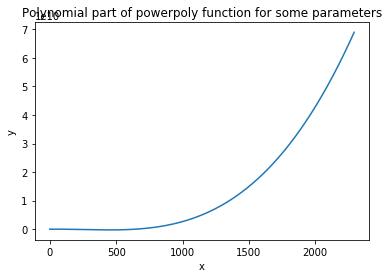

In [244]:
import matplotlib.pyplot as plt
plt.title('Polynomial part of powerpoly function for some parameters')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xdat,f3(xdat,params[3],params[4],params[5],params[6]))

In [245]:
params[0:3]

[0.041666666666666664, -4.0, 0.15]

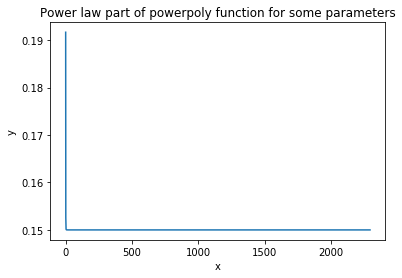

In [246]:
import matplotlib.pyplot as plt
plt.title('Power law part of powerpoly function for some parameters')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xdat[1:],powerlaw(xdat[1:],params[0:3]))
plt.show()

Okay, so fifth order boundary condition splicing is a failure because the functional form is simply not desirable. Will have to loosen constraints for this problem to work, and minimize over more variables with fewer boundary conditions. Maybe first order derivative boundary conditions would be good.  

In [247]:
def powerlaw(x,params):
    [a,b,c]=params
    return a*(x)**(-b)+c

In [248]:
def powerpoly(x,params):
    [a1,b1,c1,a2,b2,c2,d2,boundaryx]=params
    xo=[]
    for xi in x:
    
        if(xi<boundaryx):
            xo.append(f3(x,a2,b2,c2,d2))
        else:
            xo.append(powerlaw(x,a1,b1,c1))
    return xo

In [249]:
def polypowerboundaryderivconstraintanalytic(x,a1,b1,a2,b2):
    c2=(-b1*a1*x**(-b1-1)-(3*a2*x**2+2*b2*x))
    #c2=(1./6.*(x)**3-(a2*3*x**2+b2*2*x))
    return c2

def polypowerboundaryconstraintanalytic(x,a1,b1,c1,a2,b2,c2): 
    d2=(a1*x**(-b1)+c1-(a2*x**3+b2*x**2+c2*x))
    #d2=1./24.*(x)**4+c1-(1./24*x**3+b2*x**2+c2*x)
    return d2


In [250]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import row

def powerpolyparamsgen(xdat, ydat,seed, maxiter, learningrate, tol):
    
    s1=figure(height=250,width=250,title="Intercept evolution",x_axis_label="step",y_axis_label="Parameter value")
    s2=figure(height=250,width=250,title="Boundary evolution",x_axis_label="step",y_axis_label="Parameter value")
    output_notebook()
    xdat[xdat==0]=.0001
    chisq=0 #chisq is the L2 error of the fit relative to the ydata
    dof=len(xdat)-len(seed)
    [a1,b1,c1,a2,b2,c2,d2,boundaryx]=seed
    #singularity at origin
    
    c2=polypowerboundaryderivconstraintanlaytic(boundaryx,a2,b2) #first order derivative constraint
    d2=polypowerboundaryconstraintanlaytic(boundaryx,c1,a2,b2,c2) #continuity constraint
    params=np.array([a1, b1, c1,a2,b2,c2,d2])
    #these are the only free fit parameters
    fitparams=np.array([a1,b1,c1,a2,b2,boundaryx])
    addto=[True,True]
    fitparamsnext=fitparams
    #perform a variation and compare chisquareds with respect to each fit parameter
    chisqdelta=np.zeros(len(fitparams))
    for step in np.arange(maxiter):
        fitparams=fitparamsnext
        chisq=np.sum((ydat-polypower(xdat,params,boundaryx))**2)
        for i in np.arange(len(fitparams)):
            fitparamsdelta=fitparams
            fitparamsdelta[i]+=delta[i]
            a12,b12,c12,a22,b22,boundaryx2=fitparamsdelta
            #satisfy boundary conditions for new positional parameters by varying boundaryx
            d22=polypowerboundaryconstraintanalytic(boundaryx2,c12,a22,b22,c2)
            #continuity equations repeated here because each step has to be self consistent
            c22=polypowerboundaryderivconstraintanalytic(boundaryx,a22,b22) #first order derivative constraint
            d22=polypowerboundaryconstraintanalytic(boundaryx,c12,a22,b22,c22) #continuity constraint
            paramsdelta=[a12,b12,c12,a22,b22,c22,d22,boundaryx2]
            chisqdelta[i]=np.sum((ydat-polypower(xdat,paramsdelta))**2)
            if chisqdelta[i]<chisq:
                addto[i]=True
            else:
                addto[i]=False
        withintol=False
        print(fitparams, chisq)
        for i in np.arange(len(fitparams)): #check to determine whether or not _all_ components are within tolerance
            if (chisqdelta[i]-chisq)/chisq<tol:
                withintol=True
            else: 
                withintol=False
        if withintol:
            a1,b1,c1,a2,b2,boundaryx=fitparams
            c2=polypowerboundaryderivconstraintanalytic(boundaryx,a2,b2) #first order derivative constraint
            d2=polypowerboundaryconstraintanlaytic(boundaryx,c1,a2,b2,c2) #continuity constraint
            return [a1,b1,c1,a2,b2,c2,d2,boundaryx]
        for i in np.arange(len(fitparams)): #independently vary the components of the next step of fitparams
            if addto[i]:
                fitparamsnext[i]+=learningrate*fitparams[i]
            else:
                fitparamsnext[i]-=learningrate*fitparams[i]
        #use analytic gradients instead to handle boundary conditions
        #s1.circle(step,c1,color="cyan",legend="Splice intercept")
        #s2.square(step,boundaryx, color="black",legend="Splice boundary")
        #show(row(s1,s2))
    a1,b1,c1,a2,b2,boundaryx=fitparams
    c2=polypowerboundaryderivconstraintanlaytic(boundaryx,a2,b2) #first order derivative constraint
    d2=polypowerboundaryconstraintanlaytic(boundaryx,c1,a2,b2,c2) #continuity constraint
    print("max iter reached")
    return [a1,b1,c1,a2,b2,c2,d2,boundaryx]

In [251]:
sortednamedata=np.sort(wordarray, axis=0)
ydat=sortednamedata[:,0]
ydat=ydat[::-1]
xdat=np.arange(len(ydat))

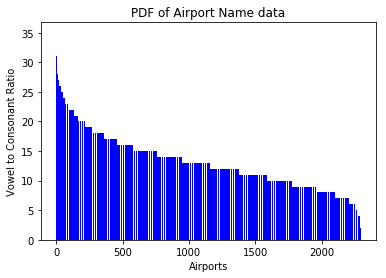

In [252]:
import matplotlib.pyplot as plt
plt.title('PDF of Airport Name data')
plt.xlabel('Airports')
plt.ylabel('Vowel to Consonant Ratio')
plt.bar(xdat,ydat,color='b')
#plt.legend(loc='upper right', frameon=False)
plt.show()

Should work for decaying power law spliced to polynomial with derivative and continuity boundary condititions, visually

In [253]:
seed1=[-0.1001773 ,  0.16004007,  0.44202822] #from power law fit earlier
seed2=[ 3.94060700e-09, -1.18255123e-05,  1.50804245e-02,  4.63688922e+00] #from polynomial fit earlier

In [254]:
maxiter=100
seed=[]
seed.extend(seed1)
seed.extend(seed2)
boundaryxseed=50
seed.append(boundaryxseed)
learningrate=0.01
tol=0.0001

Update boundary constraints and power law to remove vertical offset in power law. This simplifies continuitity boundary constraint and reduces one minimization parameter. As suggested by Robert Scholl.

In [255]:
def powerlawnooffset(x,a,b):
    return a*x**b

In [256]:
def polypowerboundaryderivconstrainteqn(x,a1,b1,a2,b2):
    c2=(b1*a1*x**(b1-1)-(3*a2*x**2+2*b2*x))
    #c2=(1./6.*(x)**3-(a2*3*x**2+b2*2*x))
    return c2

def polypowerboundaryconstrainteqn(x,a1,b1,a2,b2,c2): 
    d2=(a1*x**(b1)-(a2*x**3+b2*x**2+c2*x))
    #d2=1./24.*(x)**4+c1-(1./24*x**3+b2*x**2+c2*x)
    return d2


In [257]:
def powerpolynooffset(x,params):
    [a1,b1,a2,b2,c2,d2,boundaryx]=params
    xo=[]
    for xi in x:
    
        if(xi<boundaryx):
            xo.append(f3(x,a2,b2,c2,d2))
        else:
            xo.append(powerlawnooffset(x,a1,b1))
    return xo

In [258]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import row

def powerpolyparamsgen(xdat, ydat,seed, maxiter, learningrate, tol):
    
    s1=figure(height=250,width=250,title="Intercept evolution",x_axis_label="step",y_axis_label="Parameter value")
    s2=figure(height=250,width=250,title="Boundary evolution",x_axis_label="step",y_axis_label="Parameter value")
    output_notebook()
    xdat[xdat==0]=.0001
    chisq=0 #chisq is the L2 error of the fit relative to the ydata
    dof=len(xdat)-len(seed)
    [a1,b1,a2,b2,c2,d2,boundaryx]=seed
    #singularity at origin
    
    c2=polypowerboundaryderivconstrainteqn(boundaryx,a1,b1,a2,b2) #first order derivative constraint
    d2=polypowerboundaryconstrainteqn(boundaryx,a1,b1,a2,b2,c2) #continuity constraint
    params=np.array([a1, b1,a2,b2,c2,d2,boundaryx])
    #these are the only free fit parameters
    fitparams=np.array([a1,b1,a2,b2,boundaryx])
    fitparamsnext=fitparams
    addto=[True,True,True,True,True]
    #perform a variation and compare chisquareds with respect to each fit parameter
    chisqdelta=np.zeros(len(fitparams))
    for step in np.arange(maxiter):
        fitparams=fitparamsnext
        for i in np.arange(len(fitparams)): #independently vary the components of the next step of fitparams
            if addto[i]:
                fitparamsnext[i]+=learningrate*fitparams[i]
            else:
                fitparamsnext[i]-=learningrate*fitparams[i] 
        chisq=np.sum((ydat-powerpolynooffset(xdat,params))**2)
        for i in np.arange(len(fitparams)):
            fitparamsdelta=fitparams
            fitparamsdelta[i]=fitparamsnext[i]
            a12,b12,a22,b22,boundaryx2=fitparamsdelta
            #continuity equations repeated here because each step has to be self consistent
            c22=polypowerboundaryderivconstrainteqn(boundaryx,a12,b12,a22,b22) #first order derivative constraint
            d22=polypowerboundaryconstrainteqn(boundaryx,a12,b12,a22,b22,c22) #continuity constraint
            paramsdelta=[a12,b12,a22,b22,c22,d22,boundaryx2]
            chisqdelta[i]=np.sum((ydat-powerpolynooffset(xdat,paramsdelta))**2)
            if chisqdelta[i]<chisq:
                addto[i]=True
            else:
                addto[i]=False
        withintol=False
        print(fitparams, chisq)
        for i in np.arange(len(fitparams)): #check to determine whether or not _all_ components are within tolerance
            if (chisqdelta[i]-chisq)/chisq>tol:
                withintol=False
            else: 
                withintol=True
        if withintol:
            a1,b1,a2,b2,boundaryx=fitparams
            c2=polypowerboundaryderivconstrainteqn(boundaryx,a1,b1,a2,b2) #first order derivative constraint
            d2=polypowerboundaryconstrainteqn(boundaryx,a1,b1,a2,b2,c2) #continuity constraint
            return [a1,b1,a2,b2,c2,d2,boundaryx]
        for i in np.arange(len(fitparams)): #independently vary the components of the next step of fitparams
            if addto[i]:
                fitparamsnext[i]+=learningrate*fitparams[i]
            else:
                fitparamsnext[i]-=learningrate*fitparams[i]
        #use analytic gradients instead to handle boundary conditions
        #s1.circle(step,c1,color="cyan",legend="Splice intercept")
        #s2.square(step,boundaryx, color="black",legend="Splice boundary")
        #show(row(s1,s2))
    a1,b1,a2,b2,boundaryx=fitparams
    c2=polypowerboundaryderivconstrainteqn(boundaryx,a2,b2) #first order derivative constraint
    d2=polypowerboundaryconstrainteqn(boundaryx,a2,b2,c2) #continuity constraint
    print("max iter reached")
    return [a1,b1,a2,b2,c2,d2,boundaryx]

In [259]:
boundaryx=50
b1= polypowerboundary5derivconstraint()
a1=polypowerboundary4derivconstriant()
a2=polypowerboundary3derivconstraint(boundaryx)
b2=polypowerboundary2derivconstraint(boundaryx,a2)
c2=polypowerboundaryderivconstraint(boundaryx,a2,b2)
d2=polypowerboundaryconstraint(boundaryx,0,a2,b2,c2)

In [260]:
maxiter=100
seed=[a1,b1,a2,b2,c2,d2,boundaryx]
learningrate=0.01
tol=0.0001

In [261]:
params=powerpolyparamsgen(xdat[1:], ydat[1:],seed, maxiter, learningrate, tol)

Loading BokehJS ...

[ 4.20833333e-02 -4.04000000e+00  8.41666667e+00 -6.30618750e+03
  5.05000000e+01] 6.628369112801228e+25
[ 4.12458750e-02 -3.95960400e+00  8.24917500e+00 -6.18069437e+03
  4.94950500e+01] 6.628369112801228e+25


In [262]:
params

[0.041245875,
 -3.959604,
 8.249175,
 -6180.69436875,
 551202.0574189987,
 -13140776.368305208,
 49.49505]

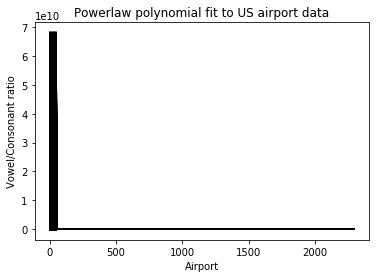

In [263]:
import matplotlib.pyplot as plt
plt.title("Powerlaw polynomial fit to US airport data")
plt.xlabel("Airport")
plt.ylabel("Vowel/Consonant ratio")
plt.bar(xdat[1:],ydat[1:], color='c')
plt.plot(xdat[1:],powerpolynooffset(xdat[1:],params), color='k')
plt.show()

Needless to say, it's a bad fit. I think the power law is the problem. I will go back to investigating other possible directions, such as the random forests Zachary Glassman suggested.'

Try requiring continuity but no first derivative.

In [264]:


def powerpolyparamsgencontinuity(xdat, ydat,seed, maxiter, learningrate, tol):
    
    s1=figure(height=250,width=250,title="Intercept evolution",x_axis_label="step",y_axis_label="Parameter value")
    s2=figure(height=250,width=250,title="Boundary evolution",x_axis_label="step",y_axis_label="Parameter value")
    output_notebook()
    xdat[xdat==0]=.0001
    chisq=0 #chisq is the L2 error of the fit relative to the ydata
    dof=len(xdat)-len(seed)
    [a1,b1,a2,b2,c2,d2,boundaryx]=seed
    #singularity at origin
    
    d2=polypowerboundaryconstrainteqn(boundaryx,a1,b1,a2,b2,c2) #continuity constraint
    params=np.array([a1, b1,a2,b2,c2,d2,boundaryx])
    #these are the only free fit parameters
    fitparams=np.array([a1,b1,a2,b2,c2,boundaryx])
    fitparamsnext=fitparams
    addto=[True,True,True,True,True,True]
    #perform a variation and compare chisquareds with respect to each fit parameter
    chisqdelta=np.zeros(len(fitparams))
    for step in np.arange(maxiter):
        fitparams=fitparamsnext
        for i in np.arange(len(fitparams)): #independently vary the components of the next step of fitparams
            if addto[i]:
                fitparamsnext[i]+=learningrate*fitparams[i]
            else:
                fitparamsnext[i]-=learningrate*fitparams[i] 
        chisq=np.sum((ydat-powerpolynooffset(xdat,params))**2)
        for i in np.arange(len(fitparams)):
            fitparamsdelta=fitparams
            fitparamsdelta[i]=fitparamsnext[i]
            a12,b12,a22,b22,c22,boundaryx2=fitparamsdelta
            #continuity equations repeated here because each step has to be self consistent
            d22=polypowerboundaryconstrainteqn(boundaryx,a12,b12,a22,b22,c22) #continuity constraint
            paramsdelta=[a12,b12,a22,b22,c22,d22,boundaryx2]
            chisqdelta[i]=np.sum((ydat-powerpolynooffset(xdat,paramsdelta))**2)
            if chisqdelta[i]<chisq:
                addto[i]=True
            else:
                addto[i]=False
        withintol=False
        print(fitparams, chisq)
        for i in np.arange(len(fitparams)): #check to determine whether or not _all_ components are within tolerance
            if (chisqdelta[i]-chisq)/chisq>tol:
                withintol=False
            else: 
                withintol=True
        if withintol:
            a1,b1,a2,b2,c2,boundaryx=fitparams
            d2=polypowerboundaryconstrainteqn(boundaryx,a1,b1,a2,b2,c2) #continuity constraint
            return [a1,b1,a2,b2,c2,d2,boundaryx]
        for i in np.arange(len(fitparams)): #independently vary the components of the next step of fitparams
            if addto[i]:
                fitparamsnext[i]+=learningrate*fitparams[i]
            else:
                fitparamsnext[i]-=learningrate*fitparams[i]
    a1,b1,a2,b2,c2,boundaryx=fitparams
    d2=polypowerboundaryconstrainteqn(boundaryx,a2,b2,c2) #continuity constraint
    print("max iter reached")
    return [a1,b1,a2,b2,c2,d2,boundaryx]

In [265]:
boundaryx=50

maxiter=100
seed=[a1,b1,a2,b2,c2,d2,boundaryx]
learningrate=0.01
tol=0.0001

In [266]:
params=powerpolyparamsgencontinuity(xdat[1:], ydat[1:],seed, maxiter, learningrate, tol)

Loading BokehJS ...

[ 4.20833333e-02 -4.04000000e+00  8.41666667e+00 -6.30618750e+03
  5.88535417e+05  5.05000000e+01] 6.641260076583539e+25
[ 4.12458750e-02 -3.95960400e+00  8.24917500e+00 -6.18069437e+03
  5.76823562e+05  4.94950500e+01] 6.641260076583539e+25


In [267]:
def powerlawnooffset(x,a,b):
    return a*x**b

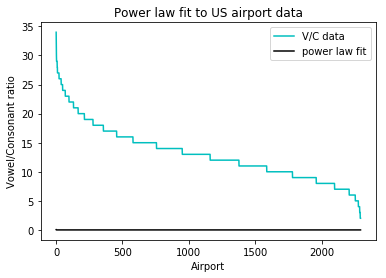

In [269]:
import matplotlib.pyplot as plt
plt.title("Power law fit to US airport data")
plt.xlabel("Airport")
plt.ylabel("Vowel/Consonant ratio")
plt.plot(xdat[1:],ydat[1:], color='c',label='V/C data')
plt.plot(xdat[1:],powerlawnooffset(xdat[1:],params[0],params[1]), color='k',label='power law fit')
plt.legend(loc="upper right")
plt.show()

Still a bad fit and I don't know why.'